In [1]:
import copy
import gzip
import itertools
import json
import pickle
import random
import re
import threading
import time
from collections import Counter
import os

import clip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from PIL import Image
from tqdm.notebook import tqdm

In [2]:
def get_steps(splits):
    if not isinstance(splits, list):
        splits = [splits]
    steps = []
    for split in splits:
        # data_path = "/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s/%s_sub.json.gz"%(split,split)
        # with gzip.open(data_path, "r") as f:
        #     data = json.loads(f.read())
        data_path = "/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s/%s_gt.json.gz"%(split,split)
        with gzip.open(data_path, "r") as f:
            data_gt = json.loads(f.read())
        steps.extend([v["forward_steps"] for k, v in data_gt.items()])
    return steps

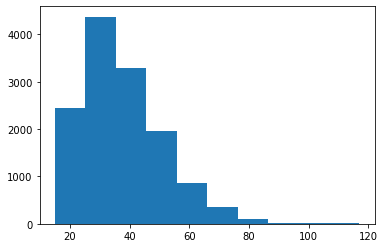

In [3]:
steps = get_steps(["val_seen","val_unseen","train"])
distribution, bins, patches = plt.hist(steps)
distribution = distribution/np.sum(distribution)

In [16]:


def random_dic(dicts):
    dict_key_ls = list(dicts.keys())
    random.shuffle(dict_key_ls)
    new_dic = {}
    for key in dict_key_ls:
        new_dic[key] = dicts.get(key)
    return new_dic
def generate_envdrop_new(distribution, bins, total=65536, target="train_envdrop_sample"):
    target_dist = np.rint(total*distribution)
    print(np.sum(target_dist))
    new_data = {}
    new_gt = {}
    # add train
    split = "train"
    train_data_path = "/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s/%s_sub.json.gz"%(split,split)
    with gzip.open(train_data_path, "r") as f:
        train_data = json.loads(f.read())
    train_data_path = "/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s/%s_gt.json.gz"%(split,split)
    with gzip.open(train_data_path, "r") as f:
        train_gt = json.loads(f.read())
    new_data["instruction_vocab"] = train_data["instruction_vocab"]
    new_data["episodes"] = train_data["episodes"]
    new_gt = train_gt.copy()
    for k, v in train_gt.items():
        b = np.argmax(bins>v["forward_steps"])-1
        target_dist[b]-=1
    # read envdrop
    split = "envdrop"
    base_num = 10837
    envdrop_data_path = "/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s/%s_gt.json.gz"%(split,split)
    with gzip.open(envdrop_data_path, "r") as f:
        envdrop_gt = json.loads(f.read())
    envdrop_data_path = "/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s/%s_sub.json.gz"%(split,split)
    with gzip.open(envdrop_data_path, "r") as f:
        envdrop_data = json.loads(f.read())
    # shift episode id
    for i,v in enumerate(envdrop_data["episodes"]):
        envdrop_data["episodes"][i]["episode_id"] += base_num
    envdrop_gt = {str(int(k)+base_num):v for k,v in envdrop_gt.items()}
    # random sample
    envdrop_gt = random_dic(envdrop_gt)
    episodes_can = []
    for k,v in envdrop_gt.items():
        b = np.argmax(bins>v["forward_steps"])-1
        if target_dist[b]>0:
            target_dist[b]-=1
            new_gt[k] = v
            episodes_can.append(int(k))
    assert np.sum(target_dist)==0, "rest"
    for e in envdrop_data["episodes"]:
        if int(e["episode_id"]) in episodes_can:
            new_data["episodes"].append(e)
    # check
    id_list = []
    assert len(new_data["episodes"])==len(new_gt), "failed"
    for e in new_data["episodes"]:
        assert (e["episode_id"] not in id_list) and (str(e["episode_id"]) in new_gt), "not done!"
    # print(train_data.keys())
    # save
    if not os.path.exists("/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s"%(target)):
        os.makedirs("/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s"%(target))
    path = "/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s/%s_sub.json.gz"%(target,target)
    with gzip.open(path, "w") as f:
        f.write(json.dumps(new_data).encode("utf-8"))
    path = "/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s/%s_gt.json.gz"%(target,target)
    with gzip.open(path, "w") as f:
        f.write(json.dumps(new_gt).encode("utf-8"))
    return new_data, new_gt
new_data, new_gt = generate_envdrop_new(distribution,bins)

65536.0


In [13]:
# for e in new_data["episodes"]:
#     if e["episode_id"]>10837:
#         print(e)
#         break
print(new_gt["10840"])

{'locations': [[-5.062699794769287, -3.508549928665161, -13.56779956817627], [-4.82098913192749, -3.508549928665161, -13.50395679473877], [-4.579278469085693, -3.508549928665161, -13.44011402130127], [-4.3375678062438965, -3.508549928665161, -13.37627124786377], [-4.087569236755371, -3.508549928665161, -13.37716293334961], [-3.837570905685425, -3.508549928665161, -13.37805461883545], [-3.5875725746154785, -3.508549928665161, -13.378946304321289], [-3.3375742435455322, -3.508549928665161, -13.379837989807129], [-3.087575912475586, -3.508549928665161, -13.380729675292969], [-2.8375775814056396, -3.508549928665161, -13.381621360778809], [-2.7720117568969727, -3.508549928665161, -13.140372276306152], [-2.7064459323883057, -3.508549928665161, -12.899123191833496], [-2.6408801078796387, -3.508549928665161, -12.65787410736084], [-2.6399881839752197, -3.508549928665161, -12.407876014709473], [-2.639096260070801, -3.508549928665161, -12.157877922058105], [-2.6825718879699707, -3.508549928665161

In [11]:

split = "envdrop"
envdrop_data_path = "/hy-tmp/data/datasets/R2R_VLNCE_v1-2_preprocessed/%s/%s.json.gz"%(split,split)
with gzip.open(envdrop_data_path, "r") as f:
    envdrop_data = json.loads(f.read())
split = "train"
train_data_path = "/hy-tmp/data/datasets/R2R_VLNCE_v1-2_preprocessed/%s/%s.json.gz"%(split,split)
with gzip.open(train_data_path, "r") as f:
    train_data = json.loads(f.read())
split = "joint_train_envdrop"
jenvdrop_data_path = "/hy-tmp/data/datasets/R2R_VLNCE_v1-2_preprocessed/%s/%s.json.gz"%(split,split)
with gzip.open(jenvdrop_data_path, "r") as f:
    jenvdrop_data = json.loads(f.read())
train_id = []
for e in train_data["episodes"]:
    train_id.append(e["episode_id"])
env_id = []
for e in envdrop_data["episodes"]:
    env_id.append(e["episode_id"])
jenv_id = []
for e in jenvdrop_data["episodes"]:
    jenv_id.append(e["episode_id"])

In [21]:
split = "train_envdrop_sample"
envdrop_data_path = "/hy-tmp/data/datasets/R2R_VLNCE_NRSub/%s/%s_sub.json.gz"%(split,split)
with gzip.open(envdrop_data_path, "r") as f:
    envdrop_data = json.loads(f.read())



In [22]:
len(envdrop_data["episodes"])

65536

In [41]:
jenvdrop_data["episodes"][10819]

{'episode_id': 10839,
 'trajectory_id': 1,
 'scene_id': 'mp3d/SN83YJsR3w2/SN83YJsR3w2.glb',
 'start_position': [2.742650032043457,
  0.09144997596740723,
  -9.057640075683594],
 'start_rotation': [0, -0.06296651502347105, 0, -0.9980156401508942],
 'info': {'geodesic_distance': 10.45021915435791},
 'goals': [{'position': [4.857450008392334,
    2.6092123985290527,
    -10.887999534606934],
   'radius': 3.0}],
 'instruction': {'instruction_text': 'walk past the table and chairs and turn right . walk up the stairs and stop at the top of the stairs .',
  'instruction_tokens': [2384,
   1589,
   2202,
   2159,
   103,
   425,
   103,
   2300,
   1819,
   9,
   2384,
   2329,
   2202,
   2058,
   103,
   2104,
   160,
   2202,
   2252,
   1472,
   2202,
   2058,
   9,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,

In [29]:
max(train_id)-10819

18